In [15]:
import numpy as np
import matplotlib.pyplot as plt
from QEDcascPy_positrons import sim_positrons_angle,sim_rr_angle
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
import gp_optimise
import importlib
import time
importlib.reload(gp_optimise)

<module 'gp_optimise' from '/mnt/c/Users/arranc/Documents/Positrons/gp_optimise/gp_optimise.py'>

In [23]:
# Sim parameters
Npoints = 10
Nsims = 1000
up_scale = 1e5
Nsamples = 1000

Nsims = 100
up_scale = 1000
Nsamples = 1e4

In [24]:
# Expt parameters
Etot = 100 # J
gamma0 = 1e9/0.511e6 # for 10 J
E0 = 10 # 10 J
gamma_spread = 0.1

# Best compression
duration0 = 25 # fs
waist0 = 2*1.22*0.8 # microns

# Random jitter
t_std = 25e-15
r_std = 20e-6

# Electron energy scaling
gscale = 1

In [25]:
# Set up the variables etc
I0 = Etot/((duration0*1e-15)*(waist0*1e-6)**2) * (4*np.log(2)/np.pi)**1.5
a0 = np.sqrt(I0/2.1378e22)

z_offset = np.random.default_rng().normal(0, 0.5*t_std*3e8, Nsims)
x_offset = np.random.default_rng().normal(0, r_std, Nsims)
y_offset = np.random.default_rng().normal(0, r_std, Nsims) 

In [26]:
# Define the MC functions to return positron number and rr rate
# Keep the offsets outside the function so I can use the same consistent offsets throughout

#dims = [{'name':'duration','type':'log-uniform','min':5,'max':100}]
#dims = [{'name':'Esplit','type':'uniform','min':0,'max':1}]
dims = [{'name':'l0','type':'log-uniform','min':0.001,'max':1}]   
    
def estimate_positrons(params): # params = [Energy split]
    t0 = time.time()
    positron = np.zeros((Nsims))
    for i in range(Nsims):
        #gamma = gamma0*((1-params[0])*Etot/10)**gscale
        #positron[i] = sim_positrons_angle(a0*np.sqrt(params[0]), gamma, gamma_spread*gamma, angle=15, 
        #                    z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=0.0,
        gamma = gamma0*((1-0.25)*Etot/E0)**gscale
        positron[i] = sim_positrons_angle(a0*np.sqrt(0.25), gamma, gamma_spread*gamma, angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=params[0],
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

    mu = np.mean(positron)
    sigma = np.std(positron)
    if (not mu>0):
        mu = 1.0/(Nsamples*up_scale)**2
        sigma = 1.0/(Nsamples*up_scale)**1.5
        
    exponent = np.floor(np.log10(mu))
    t1 = time.time()
    print("Finished %0i sims in %0.2e s at %s=%0.3f, giving (%0.2f+-%0.2f)x10^%0i positrons per electron" 
          % (Nsims,t1-t0,dims[0]['name'],params[0],mu/10**exponent,sigma/np.sqrt(Nsims)/10**exponent,exponent))
    #logmu = np.log(mu**2/np.sqrt(mu**2+sigma**2))
    logmu = np.log10(mu)
    logsigma = np.sqrt(np.log(1+sigma**2/mu**2)/Nsims)/np.log(10)

    return logmu,logsigma
    
def estimate_rr(params): # params = [Energy split]

    rr = np.zeros(Nsims)
    for i in range(Nsims):
        gamma = gamma0*((1-params[0])*Etot/10)**gscale
        rr[i] = sim_rr_angle(a0*np.sqrt(params[0]), gamma, gamma_spread*gamma, angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

    return np.mean(rr),np.std(rr)


params = [0.25]

positron = np.zeros((Nsims))
t0 = time.time()
for i in range(Nsims):
    positron[i] = sim_positrons_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=0.1,
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")
    t1 = time.time()
    exponent = np.floor(np.log10(positron[i]))
    if positron[i]==0:
        exponent=0
    print("Finished %0i sims in %0.2e s at %s=%0.2f, giving %0.2fx10^%0i positrons per electron"
          % (i+1,t1-t0,dims[0]['name'],params[0],positron[i]/10**exponent,exponent))


positron0 = sim_positrons_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=0, x_offset=0, y_offset=0,l0=0.1,
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

print(positron0)
print(np.mean(positron))
print(np.std(positron))

#positron[positron==0] = 0.1*(Nsamples*up_scale)**-1
mu = np.mean(positron)
sigma = np.std(positron)
posmean = np.log(mu**2/np.sqrt(mu**2+sigma**2))
posstd = np.sqrt(np.log(1+sigma**2/mu**2))
print('logmean =',posmean)
print('logstd =',posstd)

#npos,bins,patches = plt.hist(np.log(positron))
ngrid = np.logspace(-7,-1,num=25)
ngauss = Nsims/np.sqrt(2*np.pi*posstd**2)*np.exp(-0.5*((np.log(ngrid)-posmean)/posstd)**2)

plt.rcParams.update({'font.size': 14})

plt.subplot(4,3,4)
p1 = plt.hist(x_offset*1e6)
plt.xlabel('$\Delta x$ ($\mu$m)')
plt.ylabel('Count')

plt.subplot(4,3,5)
p2 = plt.hist(y_offset*1e6)
plt.xlabel('$\Delta y$ ($\mu$m)')

plt.subplot(4,3,6)
plt.hist(2*z_offset/3e8*1e15)
plt.xlabel('$\Delta t$ (fs)')

plt.subplot(2,1,2)
plt.hist(positron,bins=np.logspace(-7,-1,num=13),color='maroon')
plt.plot(ngrid,ngauss)

plt.xscale('log')
plt.xlabel('$N_+/N_-$')
plt.ylabel('Count')

fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(4)
plt.tight_layout()

In [27]:
kernel = 1*RBF(length_scale_bounds=(1e-1, 1e1))# + WhiteKernel(noise_level_bounds=(1e-2, 1e0))
gpo = gp_optimise.Gp_optimise(estimate_positrons,dims,kernel)

In [28]:
gpo.initialise(Ninitial=3)

Finished 100 sims in 6.33e+02 s at l0=0.350, giving (9.70+-1.73)x10^-4 positrons per electron
Finished 100 sims in 5.52e+02 s at l0=0.003, giving (9.79+-8.16)x10^-4 positrons per electron
Finished 100 sims in 1.04e+03 s at l0=0.071, giving (1.98+-0.80)x10^-3 positrons per electron


/home/arranc/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1.02**2 * RBF(length_scale=0.1)

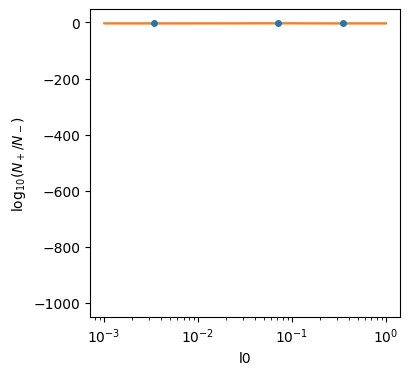

In [29]:
gpo.mean_slices_plot(40)
plt.ylabel('log$_{10}(N_+/N_-)$')
gpo.gaussian_process.kernel_

Explore 1.00, next=0.04
Explore 0.10, next=0.04


/tmp/ipykernel_22747/3779246588.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Explore %0.2f, next=%0.2f'%(explore1,gpo.Xnorm_to_X(nxt1)))
/tmp/ipykernel_22747/3779246588.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Explore %0.2f, next=%0.2f'%(explore2,gpo.Xnorm_to_X(nxt2)))


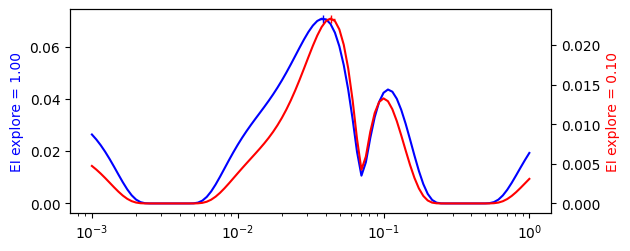

In [30]:
Nacq = 10
explore1 = 1
explore2 = 0.1

X_test = gpo.uniform_Xgrid(100)
acq_test1 = gpo.acquisition_function(gpo.X_to_Xnorm(X_test),explore=explore1,acq_fn='EI')
acq_test2 = gpo.acquisition_function(gpo.X_to_Xnorm(X_test),explore=explore2,acq_fn='EI')

nxt1 = gpo.next_acquisition(Nacq=Nacq,explore=explore1,acq_fn='EI')
nxt2 = gpo.next_acquisition(Nacq=Nacq,explore=explore2,acq_fn='EI')

plt.subplot(2,1,1)
plt.plot(X_test,acq_test1,'b')
plt.plot(gpo.Xnorm_to_X(nxt1),gpo.acquisition_function(nxt1,explore=explore1,acq_fn='EI'),'b+')
#plt.xscale('log')
plt.ylabel('EI explore = %0.2f'%explore1,color='b')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(X_test,acq_test2,'r')
ax2.plot(gpo.Xnorm_to_X(nxt2),gpo.acquisition_function(nxt2,explore=explore2,acq_fn='EI'),'r+')
plt.xscale('log')
plt.ylabel('EI explore = %0.2f'%explore2,color='r')
plt.tight_layout()

print('Explore %0.2f, next=%0.2f'%(explore1,gpo.Xnorm_to_X(nxt1)))
print('Explore %0.2f, next=%0.2f'%(explore2,gpo.Xnorm_to_X(nxt2)))

N_new = 1
gpo.optimise(N_new,Nacq=100,explore=0.01,acq_fn='EI')

plt.scatter(gpo.X,gpo.y)
y_test,std_test = gpo.predict(X_test)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
plt.scatter(gpo.X[-N_new:,0],gpo.y[-N_new:])
#plt.xscale('log')
plt.xlabel(dims[0]['name'])
plt.ylabel('log$(N_+/N_-)$')
#plt.ylim([-8,-6])

acq_test2 = gpo.acquisition_function(X_test,explore=0.01,acq_fn='EI')
gpo.next_acquisition(Nacq=10,explore=0.01,acq_fn='EI')

In [ ]:
var = 'l0'
label = '7.5GeV_20umJitter'

y_test,std_test = gpo.predict(X_test)
acq_test2 = gpo.acquisition_function(gpo.X_to_Xnorm(X_test),explore=explore2,acq_fn='EI')
nxt2 = gpo.next_acquisition(Nacq=10,explore=explore2,acq_fn='EI')
acq2 = gpo.acquisition_function(nxt2,explore=explore2,acq_fn='EI')
print('Predicted next point at %s=%0.2f, EI=%0.2f' % (var,gpo.Xnorm_to_X(nxt2),acq2))
    
np.savetxt('%s_example%i_%s.txt'%(var,len(gpo.y),label),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header=' %s\t log(N+/N-)\t error' % (var))
np.savetxt('%s_model%i_%s.txt'%(var,len(gpo.y),label),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header=' %s\t log(N+/N-)\t error' % (var))
np.savetxt('%s_acq%i_%s.txt'%(var,len(gpo.y),label),np.transpose(np.vstack((X_test[:,0],acq_test2))),header=' %s\t EI' % (var))

N_new = 1
for i in range(Npoints-len(gpo.y)):
    gpo.optimise(N_new,Nacq=10,explore=explore2,acq_fn='EI')
    y_test,std_test = gpo.predict(X_test)
    acq_test2 = gpo.acquisition_function(gpo.X_to_Xnorm(X_test),explore=explore2,acq_fn='EI')
    nxt2 = gpo.next_acquisition(Nacq=10,explore=explore2,acq_fn='EI')
    acq2 = gpo.acquisition_function(nxt2,explore=explore2,acq_fn='EI')
    print('Predicted next point at %s=%0.2f, EI=%0.2f' % (var,gpo.Xnorm_to_X(nxt2),acq2))
    
    np.savetxt('%s_example%i_%s.txt'%(var,len(gpo.y),label),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header=' %s\t log(N+/N-)\t error' % (var))
    np.savetxt('%s_model%i_%s.txt'%(var,len(gpo.y),label),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header=' %s\t log(N+/N-)\t error' % (var))
    np.savetxt('%s_acq%i_%s.txt'%(var,len(gpo.y),label),np.transpose(np.vstack((X_test[:,0],acq_test2))),header=' %s\t EI' % (var))

/tmp/ipykernel_22747/4097086125.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted next point at %s=%0.2f, EI=%0.2f' % (var,gpo.Xnorm_to_X(nxt2),acq2))


Predicted next point at l0=0.04, EI=0.02
Finished 100 sims in 1.16e+03 s at l0=0.043, giving (2.30+-1.14)x10^-3 positrons per electron
Predicted next point at l0=0.03, EI=0.01


/tmp/ipykernel_22747/4097086125.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted next point at %s=%0.2f, EI=%0.2f' % (var,gpo.Xnorm_to_X(nxt2),acq2))


Finished 100 sims in 1.25e+03 s at l0=0.027, giving (2.54+-1.44)x10^-3 positrons per electron
Predicted next point at l0=0.02, EI=0.00


/tmp/ipykernel_22747/4097086125.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted next point at %s=%0.2f, EI=%0.2f' % (var,gpo.Xnorm_to_X(nxt2),acq2))


np.savetxt('l0_example%i_7.5GeV_2.txt'%(len(gpo.y)),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header='l0\tlog(N+/N-)\terror')
np.savetxt('l0_model%i_7.5GeV_2.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header='l0\tlog(N+/N-)\terror')
np.savetxt('l0_acq%i_7.5GeV_2.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],acq_test2))),header='l0\tEI')

N_new = 1
for i in range(7):
    gpo.optimise(N_new,Nacq=100,explore=0.01,acq_fn='EI',debug=True)
    y_test,std_test = gpo.predict(X_test)
    acq_test2 = gpo.acquisition_function(gpo.X_to_Xnorm(X_test),explore=0.01,acq_fn='EI')
    nxt2 = gpo.next_acquisition(Nacq=100,explore=0.01,acq_fn='EI')
    acq2 = gpo.acquisition_function(nxt2,explore=0.01,acq_fn='EI')
    print('Predicted next point at l0=%0.2f, EI=%0.2f'%(gpo.Xnorm_to_X(nxt2),acq2))
    
    np.savetxt('l0_example%i_7.5GeV_2.txt'%(len(gpo.y)),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header='l0\tlog(N+/N-)\terror')
    np.savetxt('l0_model%i_7.5GeV_2.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header='l0\tlog(N+/N-)\terror')
    np.savetxt('l0_acq%i_7.5GeV_2.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],acq_test2))),header='l0\tEI')

np.savetxt('Esplit_example%i_scaling%0.1f_3.txt'%(len(gpo.y),gscale),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header='Esplit\tlog(N+/N-)\terror')
np.savetxt('Esplit_model%i_scaling%0.1f_3.txt'%(len(gpo.y),gscale),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header='Esplit\tlog(N+/N-)\terror')
np.savetxt('Esplit_acq%i_scaling%0.1f_3.txt'%(len(gpo.y),gscale),np.transpose(np.vstack((X_test[:,0],acq_test2))),header='Esplit\tEI')

N_new = 1
for i in range(17):
    gpo.optimise(N_new,Nacq=100,explore=0.1,acq_fn='EI')
    y_test,std_test = gpo.predict(X_test)
    acq_test2 = gpo.acquisition_function(X_test,explore=0.1,acq_fn='EI')
    np.savetxt('Esplit_example%i_scaling%0.1f_3.txt'%(len(gpo.y),gscale),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header='Esplit\tlog(N+/N-)\terror')
    np.savetxt('Esplit_model%i_scaling%0.1f_3.txt'%(len(gpo.y),gscale),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header='Esplit\tlog(N+/N-)\terror')
    np.savetxt('Esplit_acq%i_scaling%0.1f_3.txt'%(len(gpo.y),gscale),np.transpose(np.vstack((X_test[:,0],acq_test2))),header='Esplit\tEI')

In [1]:
gpo.mean_slices_plot(40)
plt.ylabel('log$_{10}(N_+/N_-)$')
gpo.gaussian_process.kernel_

NameError: name 'gpo' is not defined

In [ ]:
acq_test2 = gpo.acquisition_function(gpo.X_to_Xnorm(X_test),explore=explore2,acq_fn='EI')
nxt2 = gpo.next_acquisition(Nacq=100,explore=explore2,acq_fn='EI')
acq2 = gpo.acquisition_function(nxt2,explore=explore2,acq_fn='EI')
plt.plot(X_test,acq_test2)
plt.plot(gpo.Xnorm_to_X(nxt2),acq2,'+')
plt.xscale('log')
plt.xlabel(dims[0]['name'])
plt.ylabel('log(E.I.)')
print('Next acquisition: Xnorm =',nxt2[0], ', X =', gpo.Xnorm_to_X(nxt2)[0])

In [ ]:
estimate_positrons((0,0))